In [1]:
import numpy as np
import pandas as pd
import cv2
import pathlib
from matplotlib import pyplot as plt
import seaborn as sns
import time, random
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionV3, Xception, InceptionResNetV2,DenseNet121, MobileNet, MobileNetV2

In [2]:
files_path = '/content/drive/MyDrive/COVID_DATASET'
files_path = pathlib.Path(files_path)
files_path

PosixPath('/content/drive/MyDrive/COVID_DATASET')

In [4]:
images_dict = {
    'covid': list(files_path.glob('COVID/*')),
    'pneumonia': list(files_path.glob('PNEUMONIA/*')),
}
labels_dict = {
    'covid': 0,
    'pneumonia': 1,
}
len(images_dict['pneumonia'])

500

In [5]:
IMAGE_SHAPE = (224, 224)
X, y = [], []
for name, images in images_dict.items():
    for image in images:
        img = cv2.imread(str(image), 1)
        resized_img = cv2.resize(img, dsize=IMAGE_SHAPE)
        blurred_img = cv2.GaussianBlur(resized_img, ksize=(3, 3), sigmaX=0.5, sigmaY=0.7,
                                       borderType=cv2.BORDER_CONSTANT)
        hsv_img = cv2.cvtColor(blurred_img, cv2.COLOR_BGR2HSV)
        h, s, v = hsv_img[:, :, 0], hsv_img[:, :, 1], hsv_img[:, :, 2]
        value = 10
        limit = 255 - value
        v[v > limit] = 255
        v[v <= limit] += value
        hsv_img_new = cv2.merge((h, s, v))
        img_brightness = cv2.cvtColor(hsv_img_new, cv2.COLOR_HSV2RGB)
        img_brightness_gray = cv2.cvtColor(img_brightness, cv2.COLOR_RGB2GRAY)
        clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))
        img_hist_gray = clahe.apply(img_brightness_gray)
        img_hist = cv2.cvtColor(img_hist_gray, cv2.COLOR_GRAY2RGB)
        X.append(img_hist)
        y.append(labels_dict[name])

X = np.array(X)
y = np.array(y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)
X_train.shape

(753, 224, 224, 3)

In [7]:
X_train = X_train / 255
X_test = X_test / 255

In [8]:
data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    height_shift_range=0.2,
    width_shift_range=0.2,
    rotation_range=45,
    shear_range=0.2,
    zoom_range=0.2
)

In [9]:
def model_1(img_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16,3,padding='same',activation='relu',input_shape=(img_shape+(3,))),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32,3,padding='same',activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256,activation='relu'),
        tf.keras.layers.Dense(3,activation='softmax')
    ])
    return model

def model_2(img_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(8, 3, padding='same', activation='relu',input_shape=(img_shape+(3,))),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128,activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    return model

def model_3(img_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(8, 3, padding='same', activation='relu',input_shape=(img_shape+(3,))),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(128,3,padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(512,activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    return model


def inceptionv3(img_shape):
    model_inception = InceptionV3(include_top=False,weights='imagenet',input_shape=(img_shape+(3,)))
    for layer in model_inception.layers:
        layer.trainable = False
    model = tf.keras.Sequential([
        model_inception,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512,activation='relu'),
        tf.keras.layers.Dense(3,activation='softmax')
    ])
    return model

def mobilenet(img_shape):
    model_mobilenet = MobileNet(include_top=False, weights='imagenet', input_shape=(img_shape + (3,)))
    for layer in model_mobilenet.layers:
        layer.trainable = False
    model = tf.keras.Sequential([
        model_mobilenet,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    return model

def densenet121(img_shape):
    model_densenet121 = DenseNet121(include_top=False, weights='imagenet', input_shape=(img_shape + (3,)))
    for layer in model_densenet121.layers:
        layer.trainable = False
    model = tf.keras.Sequential([
        model_densenet121,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    return model

def xception(img_shape):
    model_xception = Xception(include_top=False, weights='imagenet', input_shape=(img_shape + (3,)))
    for layer in model_xception.layers:
        layer.trainable = False
    model = tf.keras.Sequential([
        model_xception,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    return model

def mobilenetv2(img_shape):
    model_mobilenetv2 = MobileNetV2(include_top=False, weights='imagenet', input_shape=(img_shape + (3,)))
    for layer in model_mobilenetv2.layers:
        layer.trainable = False
    model = tf.keras.Sequential([
        model_mobilenetv2,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    return model

In [10]:
model = densenet121(img_shape=(224,224))
model.summary()

29097984/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               25690624  
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 32,729,667
Trainable params: 25,692,163
Non-trainable params: 7,037,504
_________________________________________________________________


In [11]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [12]:
start_time = time.time()
train = model.fit(data_augmentation.flow(X_train, y_train,batch_size=32), epochs=100)
end_time = time.time()

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


24/24 [==============================] - 48s 453ms/step - loss: 9.9282 - accuracy: 0.6321
Epoch 2/100
24/24 [==============================] - 10s 417ms/step - loss: 0.9936 - accuracy: 0.8300
Epoch 3/100
24/24 [==============================] - 10s 421ms/step - loss: 0.6595 - accuracy: 0.8433
Epoch 4/100
24/24 [==============================] - 10s 422ms/step - loss: 0.8964 - accuracy: 0.7968
Epoch 5/100
24/24 [==============================] - 10s 422ms/step - loss: 0.8607 - accuracy: 0.8127
Epoch 6/100
24/24 [==============================] - 10s 421ms/step - loss: 0.5444 - accuracy: 0.8685
Epoch 7/100
24/24 [==============================] - 10s 418ms/step - loss: 0.7027 - accuracy: 0.8353
Epoch 8/100
24/24 [==============================] - 10s 426ms/step - loss: 0.6338 - accuracy: 0.8579
Epoch 9/100
24/24 [==============================] - 10s 420ms/step - loss: 0.7239 - accuracy: 0.8220
Epoch 10/100
24/24 [==============================] - 10s 421ms/step - loss: 0.4324 - accuracy

In [13]:
training_time = end_time - start_time
training_time

1105.202008008957

In [14]:
test = model.evaluate(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


8/8 [==============================] - 5s 440ms/step - loss: 0.2678 - accuracy: 0.9044


In [15]:
y_pred = model.predict(X_test)
y_pred = [np.argmax(i) for i in y_pred]
y_pred = np.array(y_pred)
y_pred

array([1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 0])

In [16]:
# Classification Report
cr = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
df_cr = pd.DataFrame(cr).transpose()
df_cr = df_cr.rename(index={'0': 'Covid-19', '1': 'Pneumonia'})
df_cr

,precision,recall,f1-score,support
Covid-19,0.903226,0.903226,0.903226,124.000000
Pneumonia,0.905512,0.905512,0.905512,127.000000
accuracy,0.904382,0.904382,0.904382,0.904382
macro avg,0.904369,0.904369,0.904369,251.000000
weighted avg,0.904382,0.904382,0.904382,251.000000


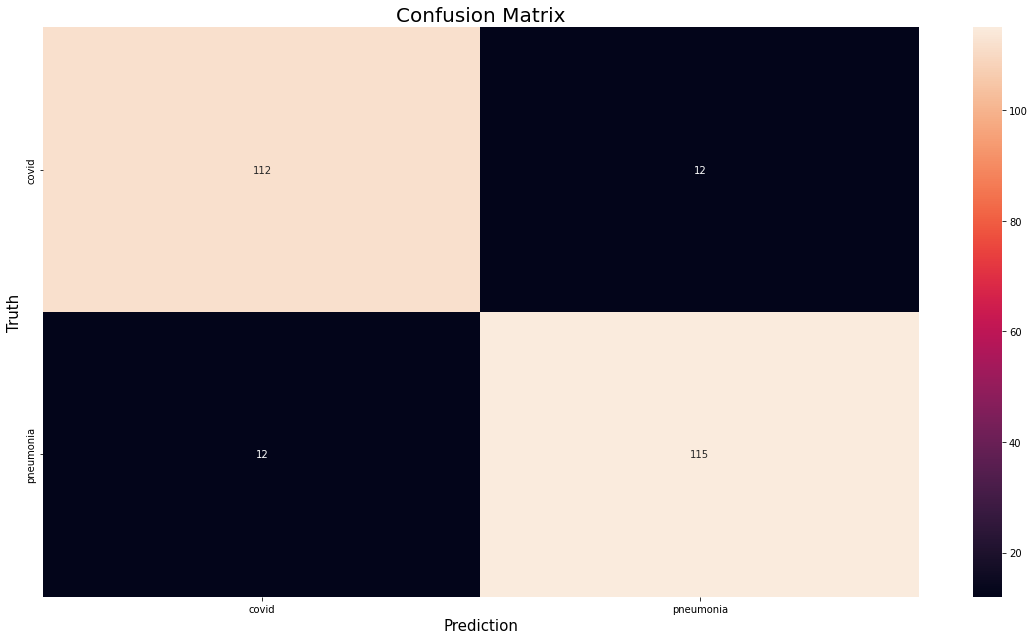

In [17]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=[i for i, j in labels_dict.items()], columns=[i for i, j in labels_dict.items()])
fig = plt.figure(figsize=(16, 9))
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title('Confusion Matrix', fontsize=20)
plt.xlabel('Prediction', fontsize=15)
plt.ylabel('Truth', fontsize=15)
plt.tight_layout()
plt.show()

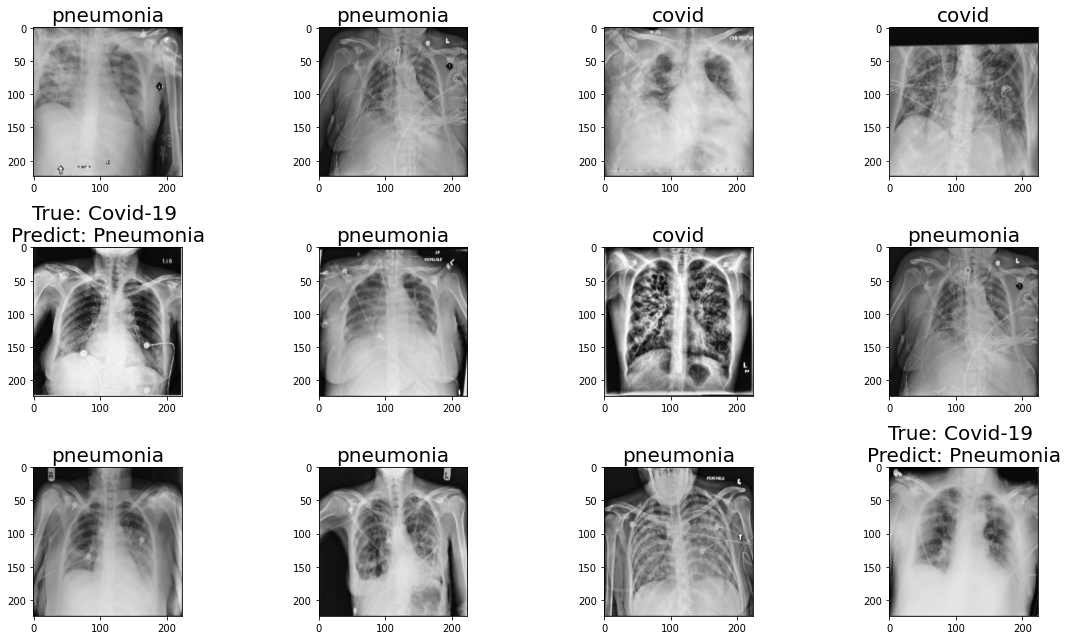

In [18]:
labels = list(map(lambda x: 'a', range(0, len(y_test))))
first_labels = [i for i, j in labels_dict.items()]
for i in range(len(y_test)):
    if y_test[i] == y_pred[i]:
        labels[i] = first_labels[y_pred[i]]
    elif y_test[i] == 0 and y_pred[i] == 1:
        labels[i] = 'True: Covid-19 \nPredict: Pneumonia'
    elif y_test[i] == 1 and y_pred[i] == 0:
        labels[i] = 'True: Pneumonia\nPredict: Covid-19'


r = 3
c = 4
fig, axes = plt.subplots(r, c, figsize=(16, 9))
for i in range(0, r):
    for j in range(0, c):
        rand = random.randint(0, len(X_test))
        axes[i, j].imshow(X_test[rand])
        axes[i, j].set_title(labels[rand], fontsize=20)
plt.tight_layout()
plt.show()

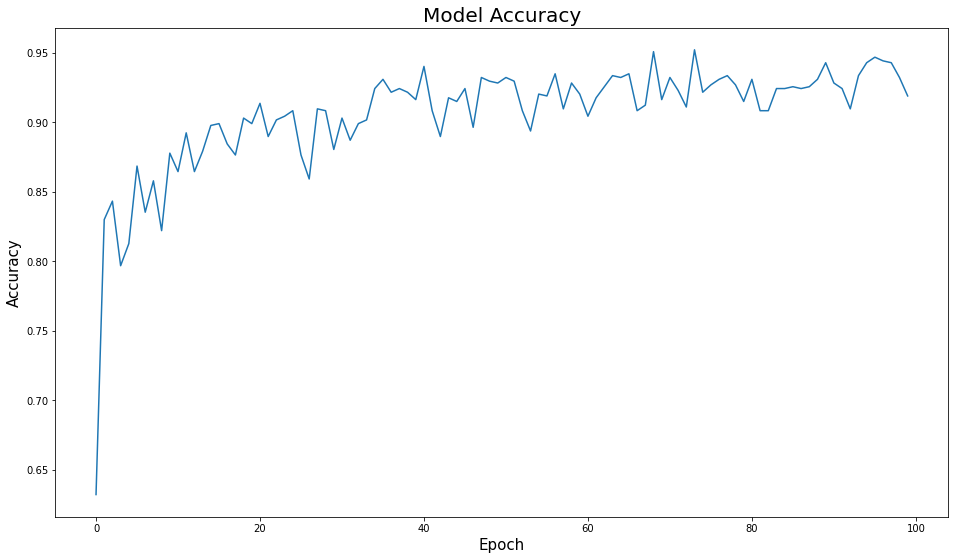

In [19]:
n_epochs = len(train.history['accuracy'])
fig_acc = plt.figure(0, figsize=(16, 9))
plt.plot(range(n_epochs), train.history['accuracy'])
plt.title('Model Accuracy', fontsize=20)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.show()

Text(0, 0.5, 'Loss')

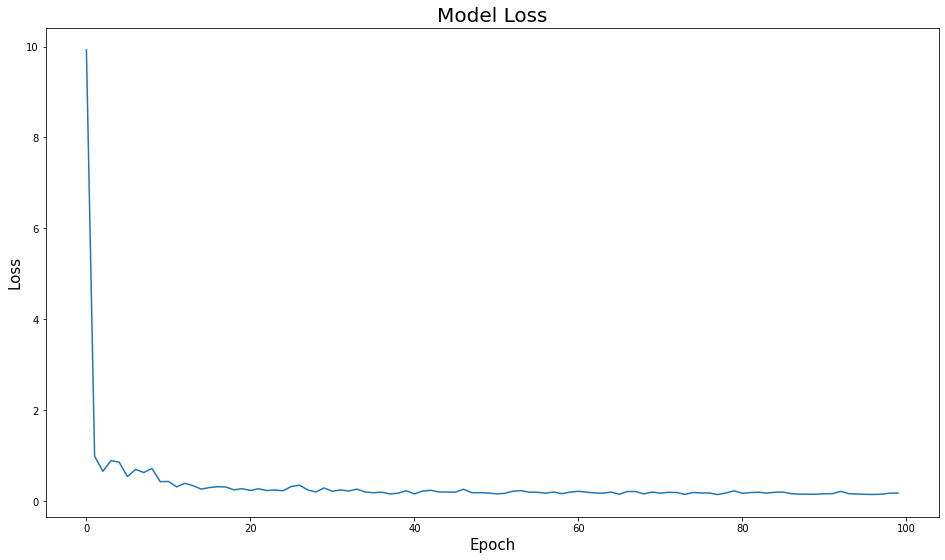

In [20]:
fig_loss = plt.figure(1, figsize=(16, 9))
plt.plot(range(n_epochs), train.history['loss'])
plt.title('Model Loss', fontsize=20)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)


Text(0, 0.5, 'True Positive Rate')

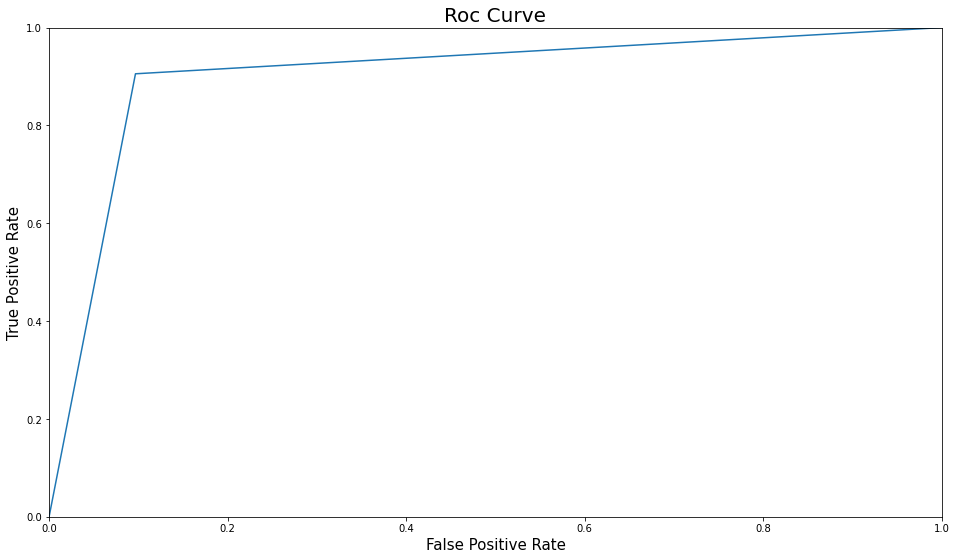

In [21]:
fpr,tpr,_ = roc_curve(y_test,y_pred)
plt.figure(figsize=(16,9))
plt.plot(fpr,tpr)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('Roc Curve', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)